In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import WMA as wma
import load_wrds
warnings.filterwarnings("ignore")

In [2]:
# 13f data for the top 15 most followed fund managers
path = '/Users/kaiwentay/Documents/GitHub/Weighted-Majority-Experts/Data/Pulled/mngrdata.parquet'
df = pd.read_parquet(path)
# crsp data for stock price and returns
path2 = '/Users/kaiwentay/Documents/GitHub/Weighted-Majority-Experts/Data/Pulled/crsp_data.parquet'
df2 = pd.read_parquet(path2)

# create combined dataframe
df_grouped = load_wrds.load_combined_grouped(df, df2)

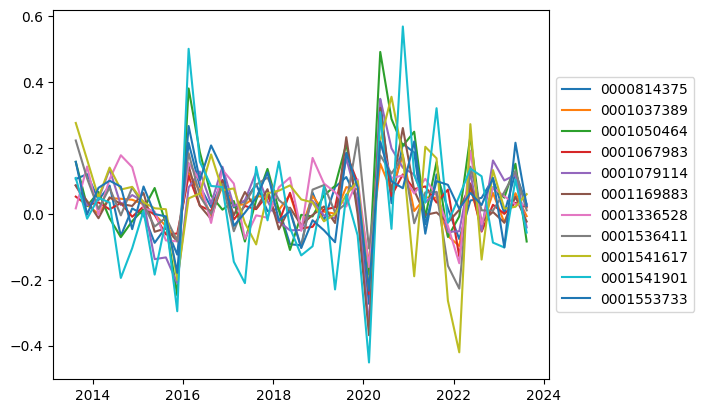

In [3]:
# plot performance of each cik over time
for cik in df_grouped['cik'].unique():
    df_temp = df_grouped[df_grouped['cik'] == cik]
    plt.plot(df_temp['new_fdate'], df_temp['weighted_performance'], label=cik)
# legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

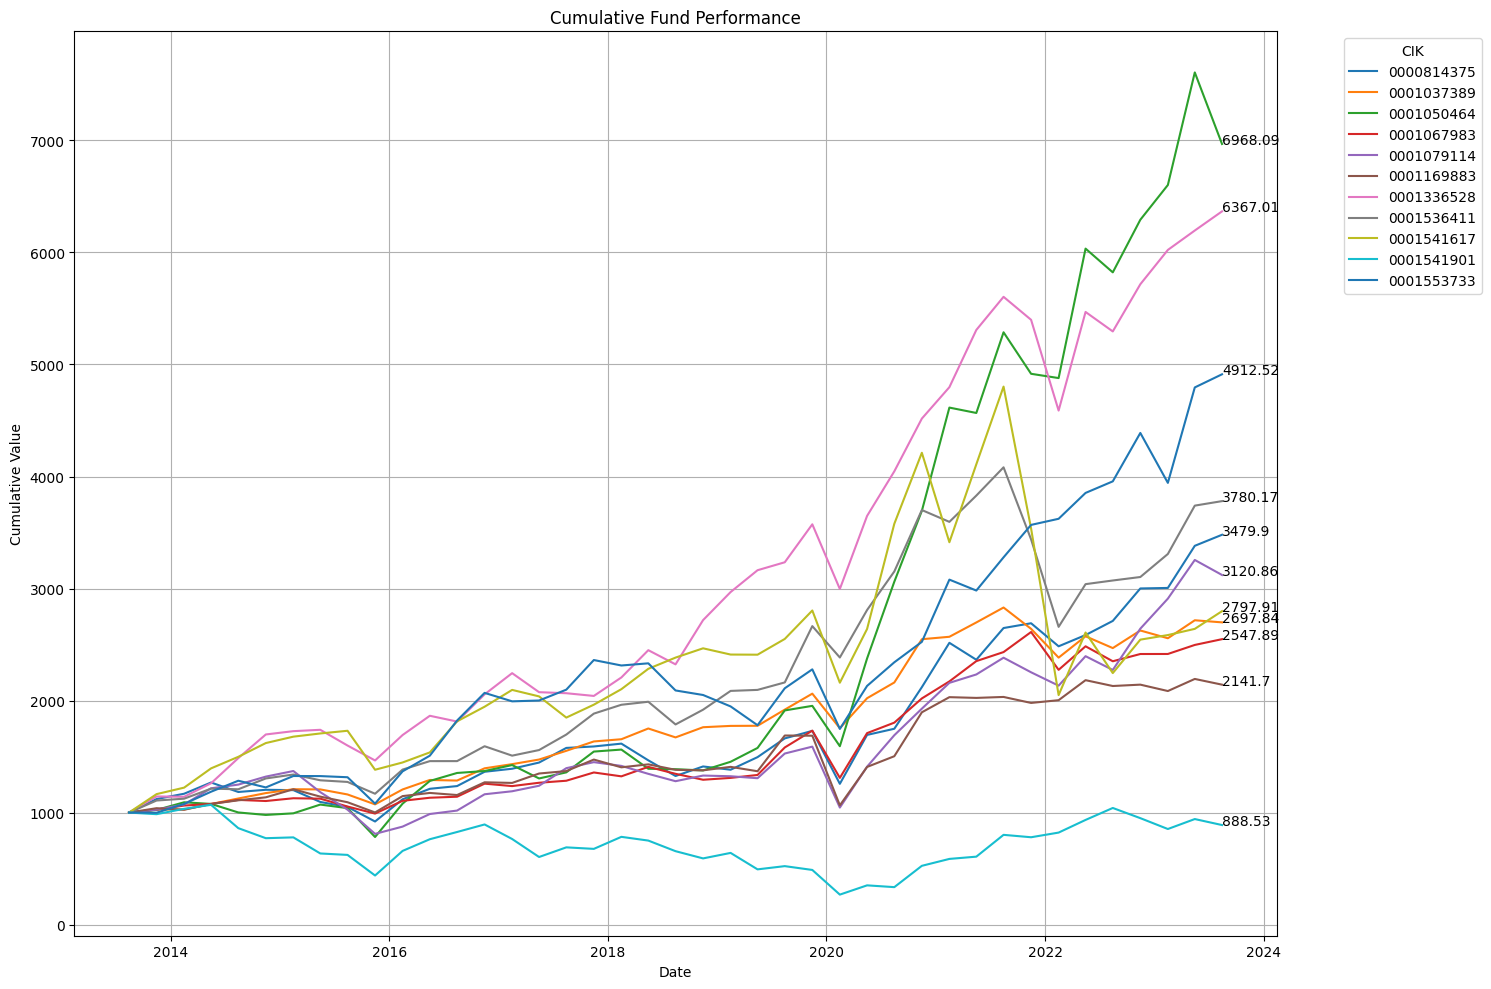

In [4]:
def plot_individual_cumulative_performance(df_grouped, initial_value=1000):
    # Pivot the DataFrame to have new_fdate as index and cik as columns
    performance_pivot = df_grouped.pivot(index='new_fdate', columns='cik', values='weighted_performance')
    
    # Initialize a DataFrame to store cumulative performance
    cumulative_performance = pd.DataFrame(index=performance_pivot.index, columns=performance_pivot.columns)
    
    # Set initial value for each fund
    cumulative_performance.iloc[0] = initial_value
    
    # Calculate cumulative performance
    for cik in performance_pivot.columns:
        for i in range(1, len(performance_pivot)):
            cumulative_performance.iloc[i][cik] = cumulative_performance.iloc[i-1][cik] * (1 + performance_pivot.iloc[i][cik])
    
    # Plot cumulative performance for each fund
    plt.figure(figsize=(15, 10))
    for cik in cumulative_performance.columns:
        plt.plot(cumulative_performance.index, cumulative_performance[cik], label=str(cik))
    
    plt.title('Cumulative Fund Performance')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Value')
    plt.legend(title='CIK', bbox_to_anchor=(1.05, 1), loc='upper left')

    # label the final value of each fund at the end of the final date
    for cik in cumulative_performance.columns:
        plt.text(cumulative_performance.index[-1], cumulative_performance[cik].iloc[-1], str(round(cumulative_performance[cik].iloc[-1], 2)))
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_individual_cumulative_performance(df_grouped, initial_value=1000)

## Perfect Hindsight
- We can always choose the best possible move if we know the future.
- In this case, we show the performance if we invest all the money in the best fund manager every quarter.

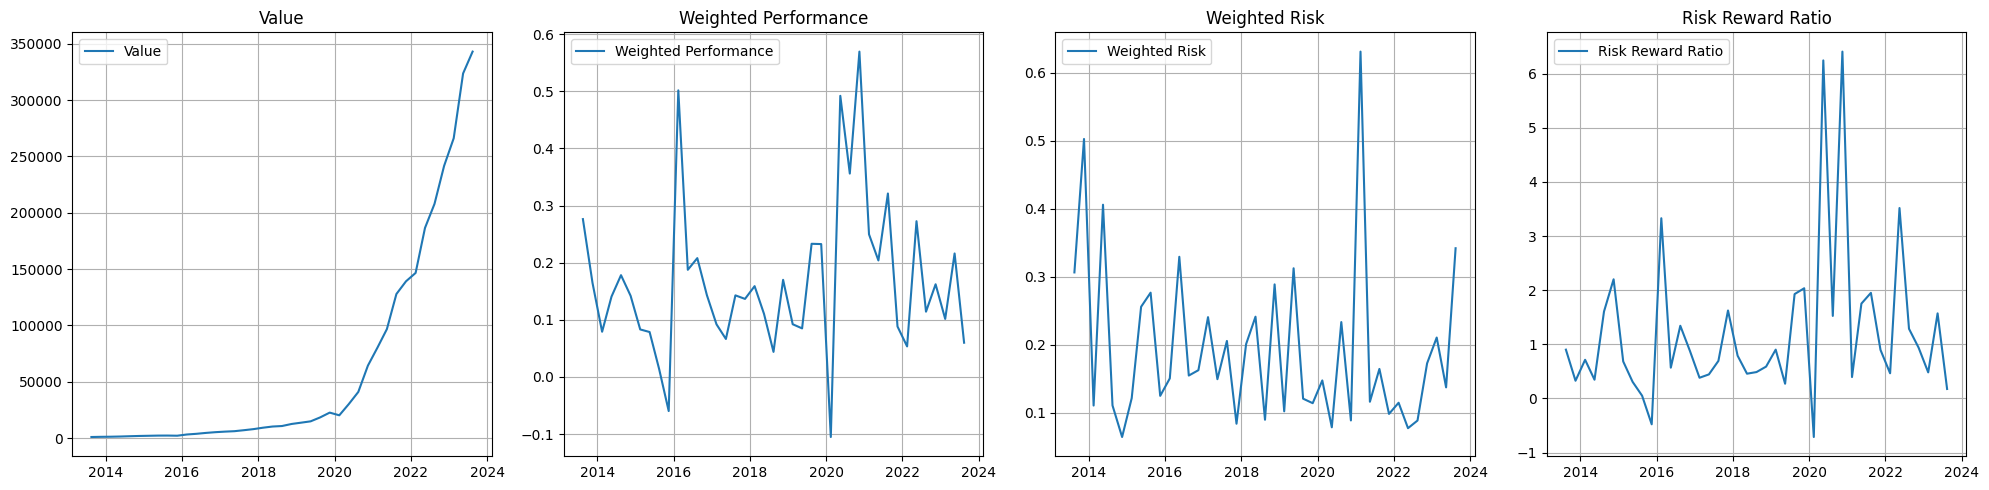

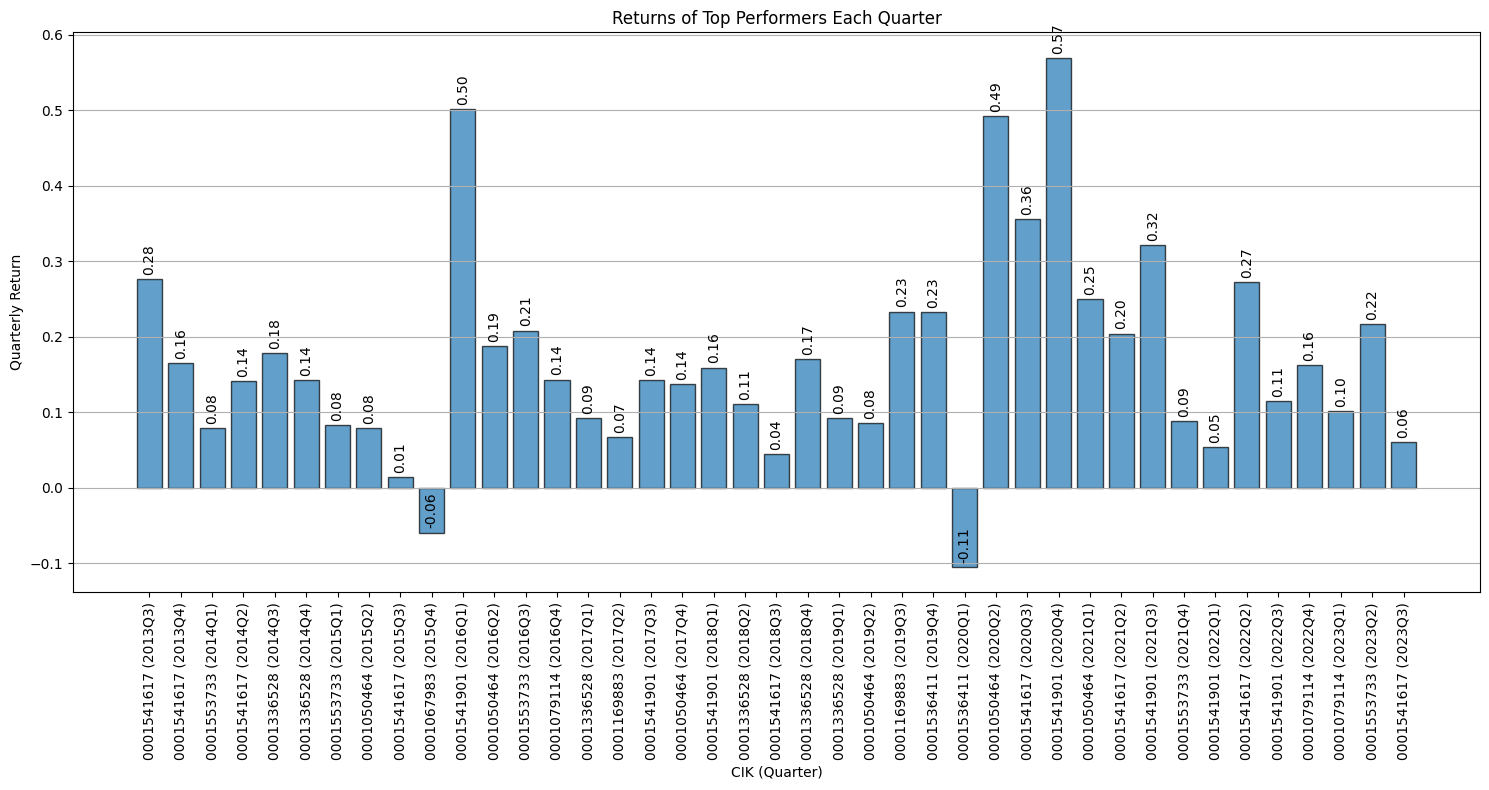

In [6]:
initial_value = 1000
perfect_hindsight = wma.perfect_hindsight_strategy(df_grouped, initial_value)

## Equal Weight
- We can also choose to invest equally in all the fund managers.
- This is a simple strategy that can be used as a benchmark.

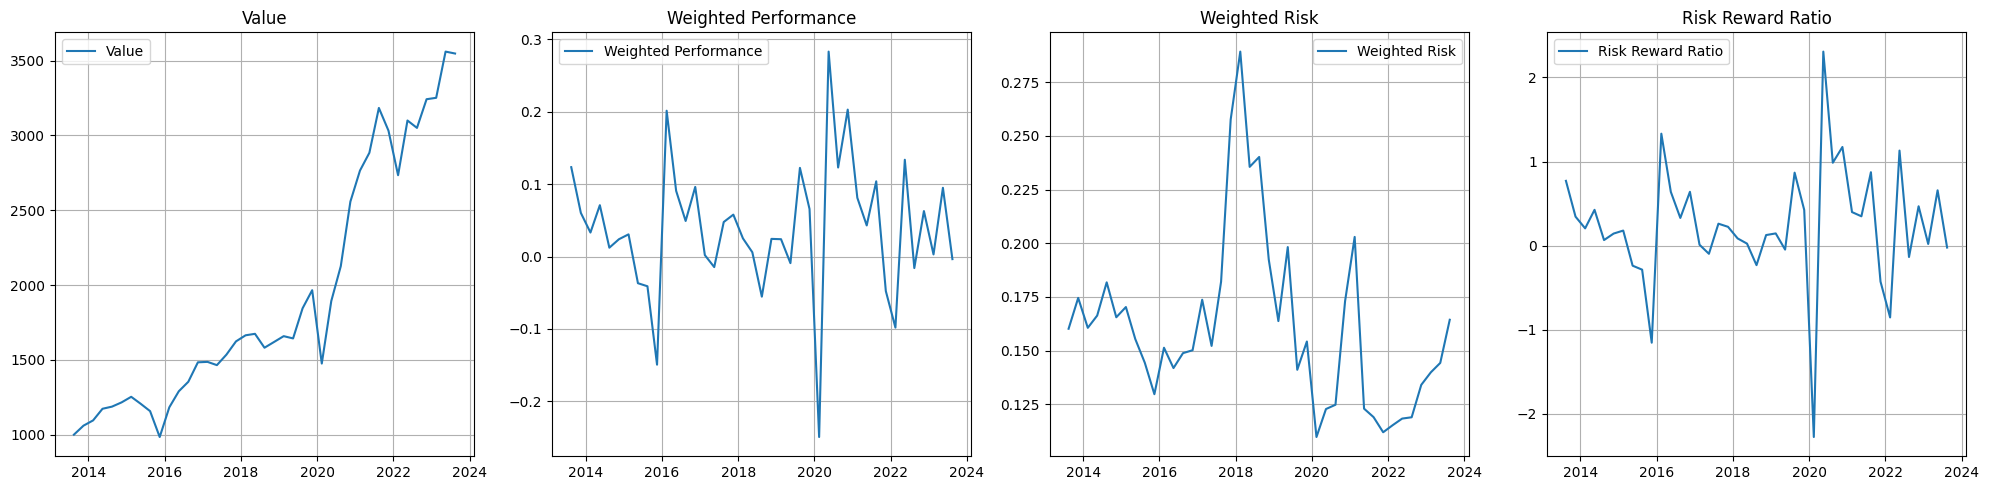

In [7]:
equal_weighted = wma.equal_weighted_strategy(df_grouped, initial_value)

## Greedy Algorithm
- We can also use a greedy algorithm to choose the best fund manager every quarter.
- We will choose the fund manager that has the highest return in the previous quarter and reduce all the other fund managers' weights by a certain beta

Optimal beta: 0.7999999999999999
Final value with optimal beta: 8506.521561074154


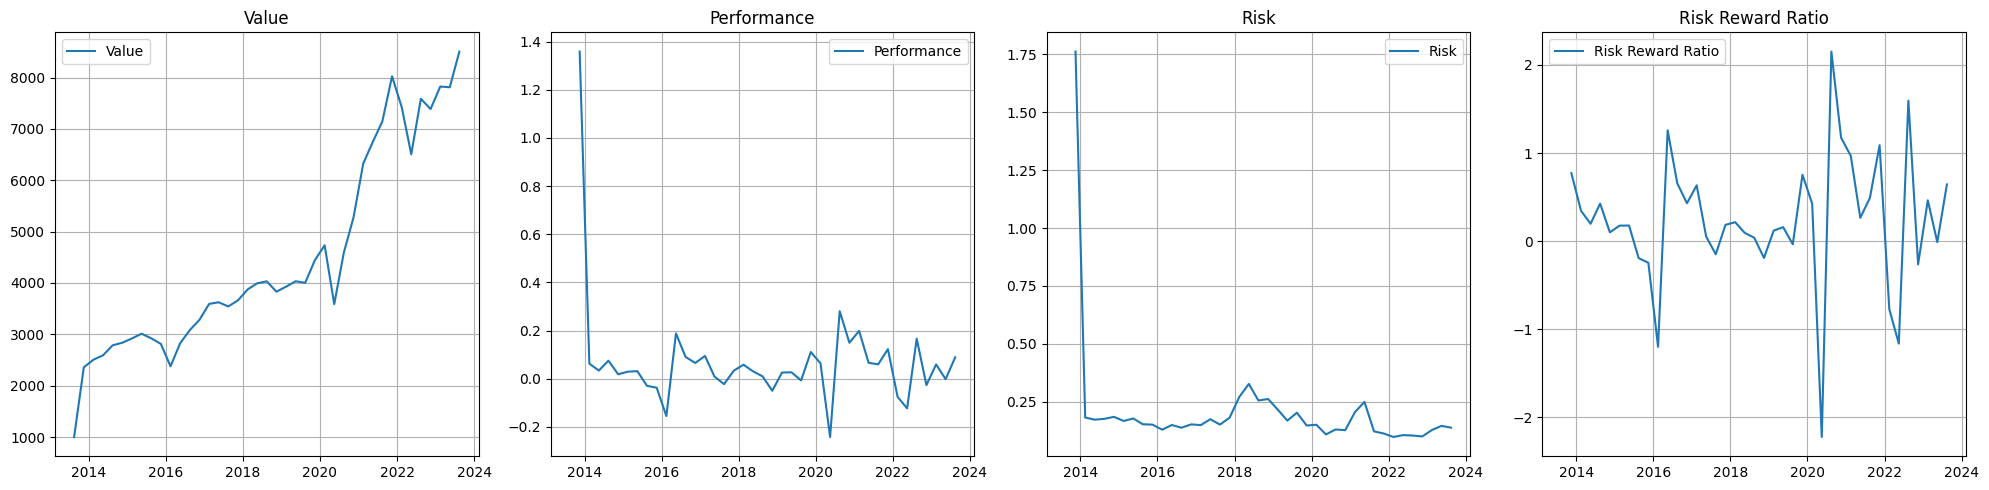

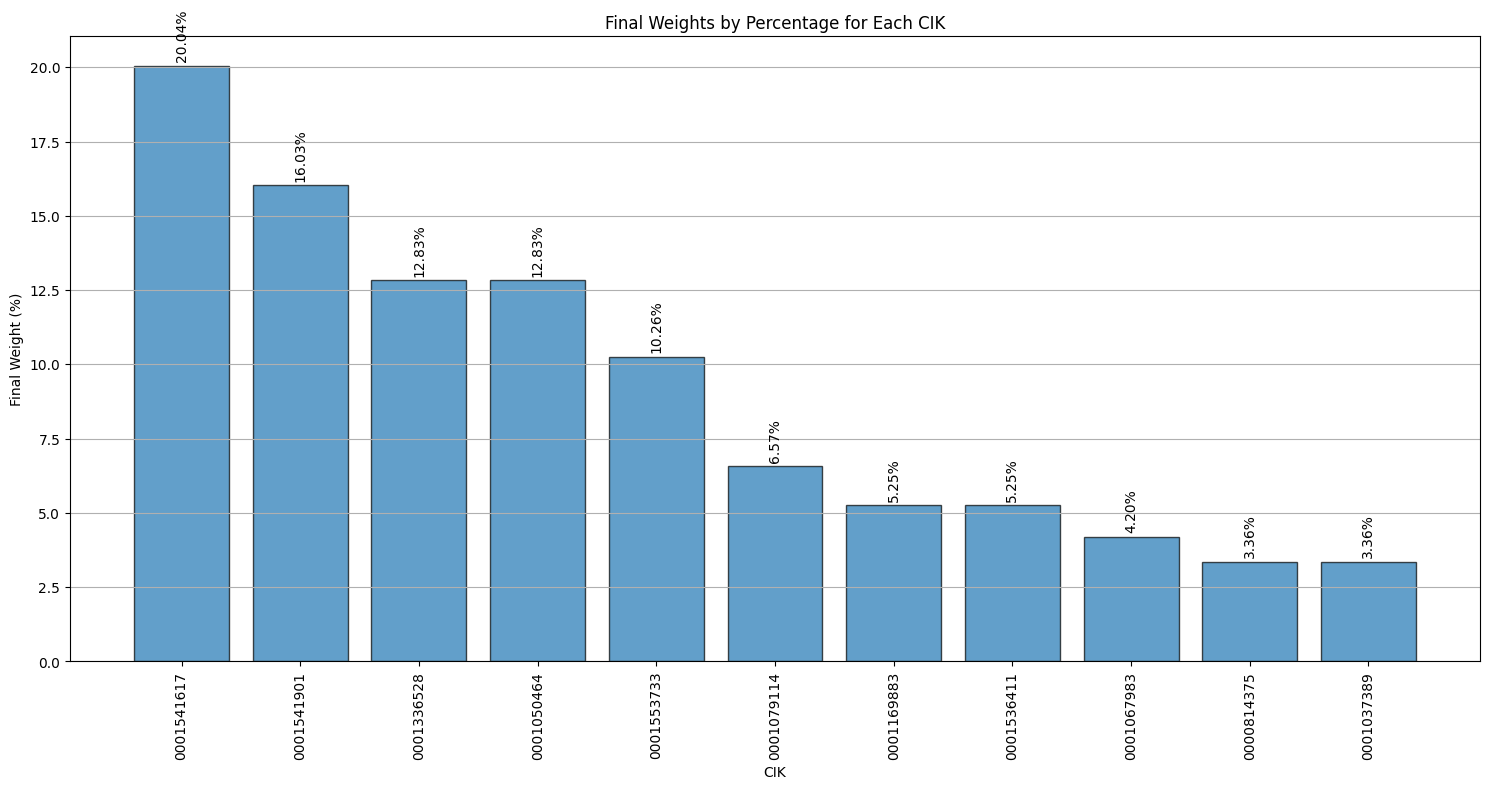

In [9]:
beta_values = np.linspace(0.1, 1.5, 15)
best_performance, best_weights = wma.greedy_strategy(df_grouped, beta_values, initial_value=1000)

# Weighted Majority Algorithm
- We can use the weighted majority algorithm to decide how much to invest in each fund manager on a quarterly basis based on their past performance.
- The algorithm is as follows:
    1. Initialize the weights of all the fund managers to 1.
    2. For each quarter, calculate the total return of each fund manager.
    3. Calculate the total return of the weighted majority algorithm by multiplying the weights of each fund manager by their total return and summing them up.
    4. Penalize the weights of the fund managers that performed poorly by multiplying them by some factor
    5. Repeat steps 2-4 for each quarter.
- We can tune the factor to get the best performance.

Optimal beta: 1.0999999999999999
Final value with optimal beta: 3099.3917905046596


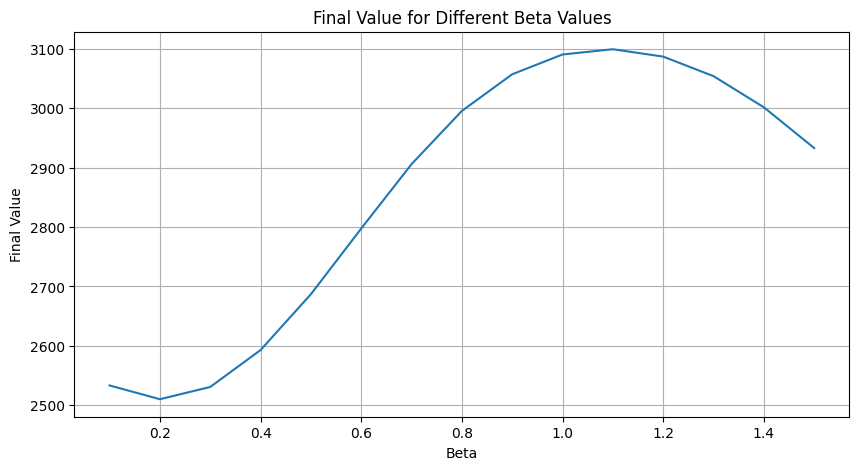

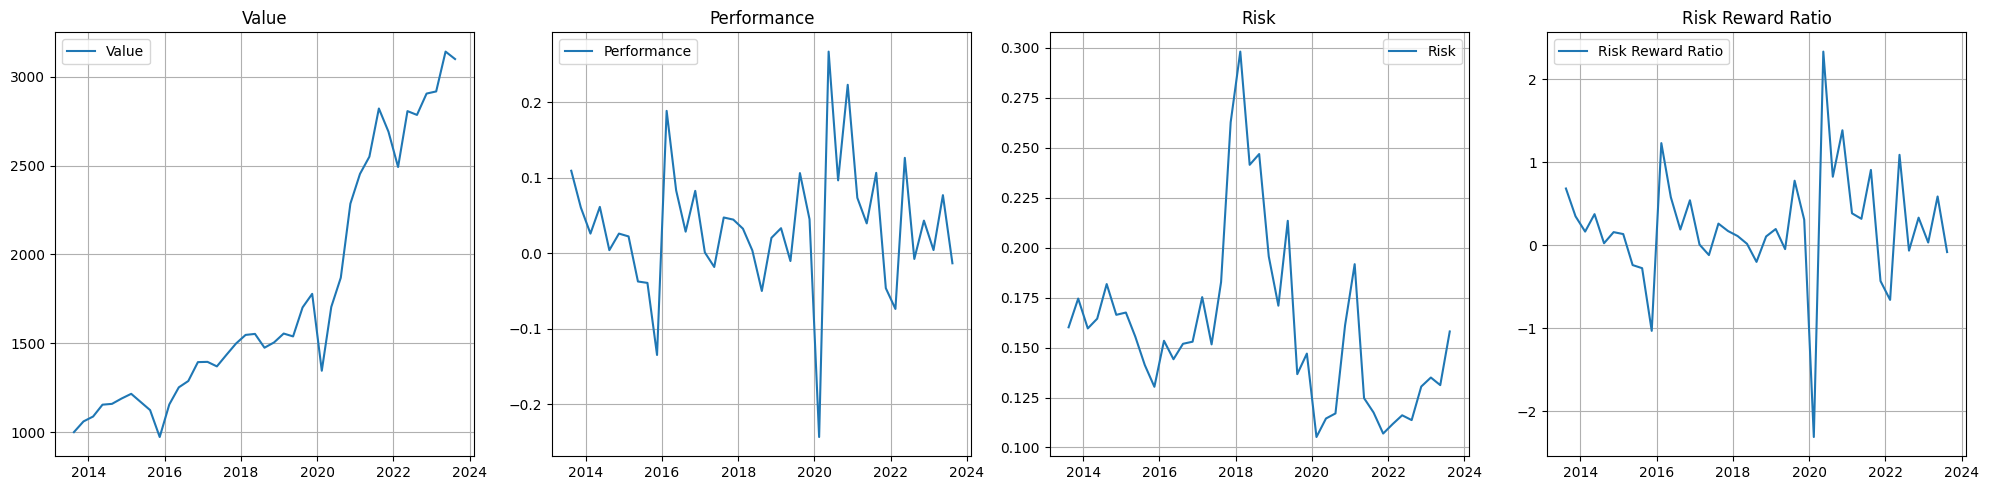

In [10]:
beta_values = np.linspace(0.1, 1.5, 15)
WMA, optimal_beta, optimal_final_value = wma.weighted_majority_algorithm(df_grouped, beta_values)

## Randomized Weighted Majority Algorithm
- We can also use the randomized weighted majority algorithm to decide how much to invest in each fund manager on a quarterly basis based on their past performance.
- The algorithm is as follows:
    1. Initialize the weights of all the fund managers to 1.
    2. For each quarter, calculate the total return of each fund manager.
    3. Calculate the total return of the randomized weighted majority algorithm by multiplying the weights of each fund manager by their total return and summing them up.
    4. Penalize the weights of the fund managers that performed poorly by multiplying them by some factor
    5. Select a random fund manager to invest in based on the weights of the fund managers.
    6. Repeat steps 2-5 for each quarter.

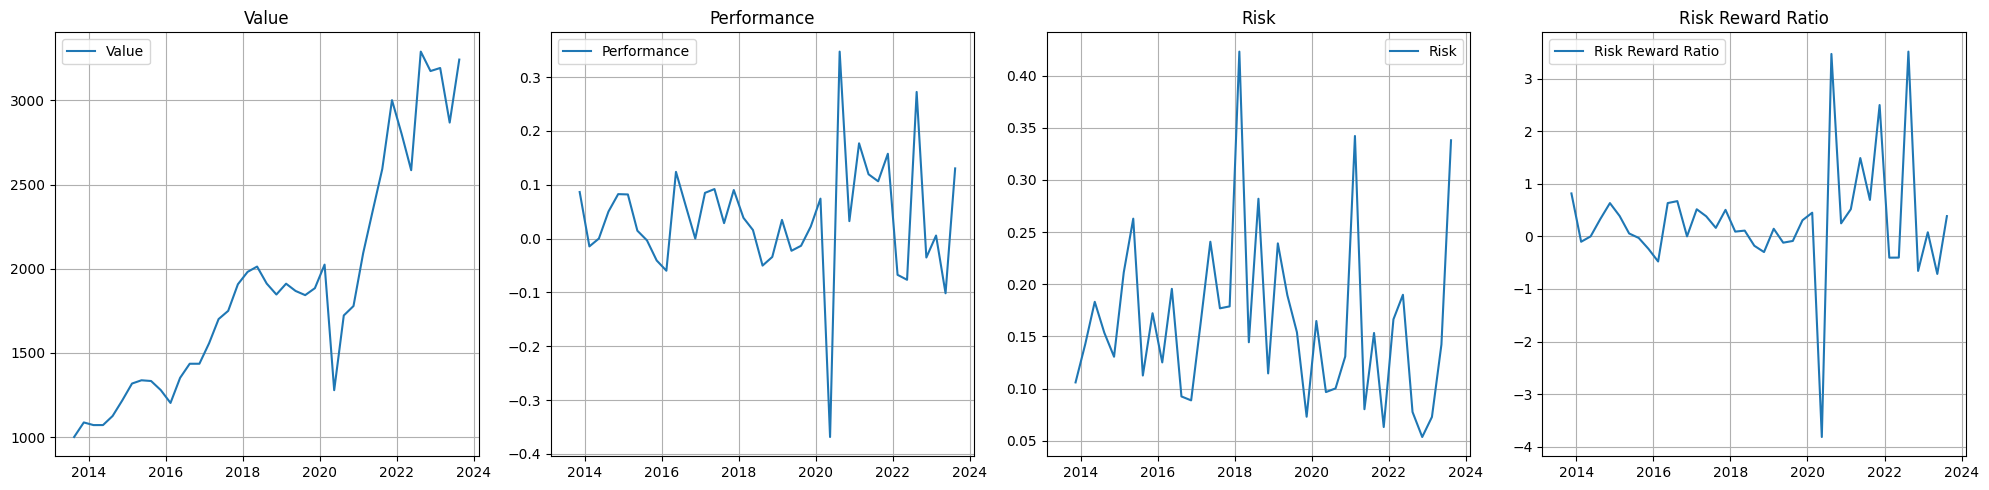

In [11]:
metrics = wma.randomized_weighted_majority_algorithm(df_grouped, initial_value=1000, beta=1.1)

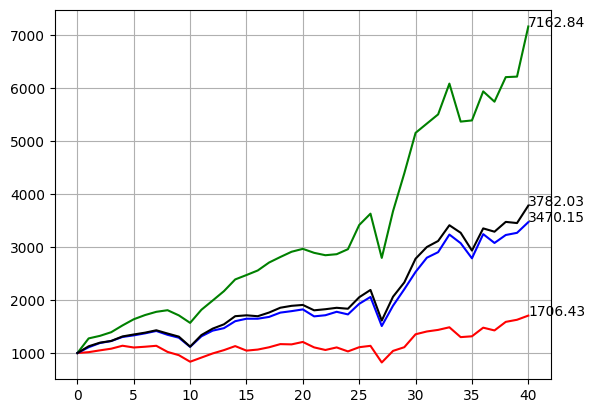

In [13]:
# running this RWMA 100 times and plotting the values over time
values = metrics['Value']
for i in range(100):
    metrics = wma.randomized_weighted_majority_algorithm(df_grouped, initial_value=1000, beta=1.1, plot=False)
    # connect new values to the previous values as a new column
    values = np.vstack((values, metrics['Value']))

# find the lwoer and upper bounds of the values
lower_bound = np.percentile(values, 5, axis=0)
upper_bound = np.percentile(values, 95, axis=0)
median = np.median(values, axis=0)
mean = np.mean(values, axis=0)

# plot the lower and upper bounds
plt.plot(lower_bound, color='red')
plt.plot(upper_bound, color='green')
plt.plot(median, color='blue')
plt.plot(mean, color='black')

#indicate the final values for the upper, lower and median bounds at the end of the final date
plt.text(len(lower_bound)-1, lower_bound[-1], str(round(lower_bound[-1], 2)))
plt.text(len(upper_bound)-1, upper_bound[-1], str(round(upper_bound[-1], 2)))
plt.text(len(median)-1, median[-1], str(round(median[-1], 2)))
plt.text(len(mean)-1, mean[-1], str(round(mean[-1], 2)))
plt.grid(True)
plt.show()